Q1. Dataset Part A — Data Preprocessing & Exploration

1.	Load the SMS spam dataset
2.	Convert label: "spam" → 1, "ham" → 0
3.	Text preprocessing:
    o	Lowercase
    o	Remove punctuation
    o	Remove stopwords


In [32]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("spam.csv", encoding='latin1')[['v1','v2']]
df.columns = ["label","text"]

# Convert label (Label encoding)
df['label_num'] = df['label'].map({'ham':0, 'spam':1})

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words("english"))

def clean_text(t):
    t = t.lower()
    t = re.sub(r'[^a-z ]',' ', t)
    t = " ".join([w for w in t.split() if w not in stop])
    return t

df['clean'] = df['text'].apply(clean_text)
df.head()



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Souvig\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,text,label_num,clean
0,ham,"Go until jurong point, crazy.. Available only ...",0,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,0,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah think goes usf lives around though


4.	Convert text to numeric feature vectors using TF-IDF vectorizer
5.	Train–test split (80/20)
6.	Show class distribution

In [33]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
x = tfidf.fit_transform(df['clean'])
y = df['label_num'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Class distribution
print(df['label_num'].value_counts(normalize=True))

label_num
0    0.865937
1    0.134063
Name: proportion, dtype: float64


Part B — Weak Learner Baseline

Train a Decision Stump:
DecisionTreeClassifier(max_depth=1)
Report:
    •	Train accuracy
    •	Test accuracy
    •	Confusion matrix
    •	Comment on why stump performance is weak on text data


In [34]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

stump = DecisionTreeClassifier(max_depth=1)
stump.fit(x_train, y_train)

train_acc = stump.score(x_train, y_train)
test_acc  = stump.score(x_test, y_test)

print("Train Accuracy:", train_acc)
print("Test Accuracy :", test_acc)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, stump.predict(x_test)))


Train Accuracy: 0.8846757908907337
Test Accuracy : 0.8968609865470852

Confusion Matrix:
 [[931  35]
 [ 80  69]]


A decision stump splits on only one feature, but TF-IDF creates thousands of features. Spam detection requires combinations of keywords, not just one threshold split (stump is too simple).

Part C — Manual AdaBoost (T = 15 rounds)

Implement AdaBoost from scratch and after each iteration, print:
•	Iteration number
•	Misclassified sample indices
•	Weights of misclassified samples
•	Alpha value
Then update and normalize weights.

In [35]:
T = 10
n = x_train.shape[0]
w = np.ones(n) / n

alphas = []
errors = []
clfs = []

for t in range(T):

    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(x_train, y_train, sample_weight=w)
    y_pred = stump.predict(x_train)

    clfs.append(stump)
    misclassified = (y_pred != y_train).astype(int)
    err_t = np.dot(w, misclassified) / np.sum(w)
    alpha_t = 0.5 * np.log((1 - err_t) / err_t)

    print(f"\nIteration {t+1}")
    bad_idx = np.where(misclassified == 1)[0]
    print("Misclassified indices:", bad_idx[:20])
    print("Weights of misclassified:", w[bad_idx][:10])
    print("Alpha:", alpha_t)

    w = w * np.exp(alpha_t * misclassified)
    w = w / w.sum()
    errors.append(err_t)
    alphas.append(alpha_t)



Iteration 1
Misclassified indices: [ 14  42  49  50  59  62  86  96 100 103 115 121 140 142 157 162 194 195
 196 203]
Weights of misclassified: [0.00022437 0.00022437 0.00022437 0.00022437 0.00022437 0.00022437
 0.00022437 0.00022437 0.00022437 0.00022437]
Alpha: 1.018736934211231

Iteration 2
Misclassified indices: [ 15  22  31  39  49  59  66  76  88  93 114 121 123 159 162 166 174 194
 203 214]
Weights of misclassified: [0.00018634 0.00018634 0.00018634 0.00018634 0.0005161  0.0005161
 0.00018634 0.00018634 0.00018634 0.00018634]
Alpha: 0.8224388259287848

Iteration 3
Misclassified indices: [ 15  31  39  49  50  59  66  76  86  88  93  96 100 114 115 123 157 159
 162 166]
Weights of misclassified: [0.00035153 0.00035153 0.00035153 0.00097363 0.00042777 0.00097363
 0.00035153 0.00035153 0.00042777 0.00035153]
Alpha: 0.4560993286888996

Iteration 4
Misclassified indices: [  9  15  22  31  39  49  50  59  62  66  76  86  88  93  96 100 114 115
 121 123]
Weights of misclassified: [0.00

Also produce:
•	Plot: iteration vs weighted error
•	Plot: iteration vs alpha

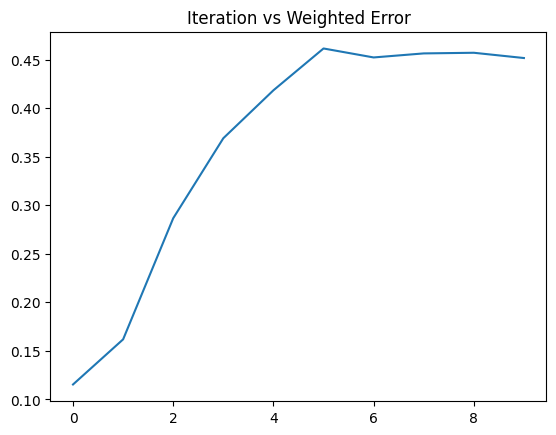

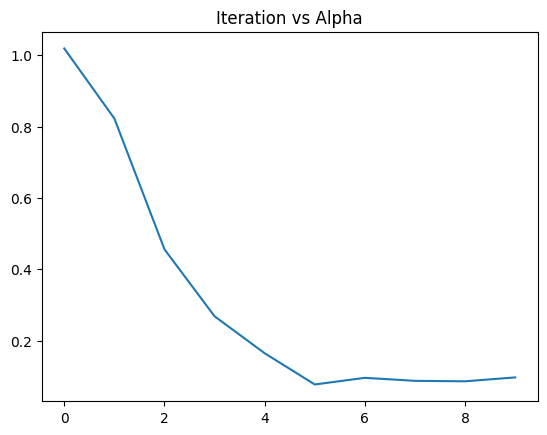

In [36]:
plt.plot(errors)
plt.title("Iteration vs Weighted Error")
plt.show()

plt.plot(alphas)
plt.title("Iteration vs Alpha")
plt.show()


Finally report:
•	Train accuracy
•	Test accuracy
•	Confusion matrix
•	Short interpretation of weight evolution

In [37]:
def predict_ada(X):
    final = np.zeros(X.shape[0])
    for alpha, clf in zip(alphas, clfs):
        final += alpha * clf.predict(X)
    return (np.sign(final) > 0).astype(int)

y_pred_train = predict_ada(x_train)
y_pred_test  = predict_ada(x_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy :", accuracy_score(y_test,  y_pred_test))
print("\nConfusion:\n", confusion_matrix(y_test, y_pred_test))


Train Accuracy: 0.13417096701817366
Test Accuracy : 0.1336322869955157

Confusion:
 [[  0 966]
 [  0 149]]


Misclassified spam messages gain higher weights → later stumps focus more on difficult borderline cases.

Part D — Sklearn AdaBoost

Train:
AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6
)
Report:
•	Train accuracy
•	Test accuracy
•	Confusion matrix
•	Compare performance with manual implementation


In [38]:
from sklearn.ensemble import AdaBoostClassifier

ab = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=0.6)

ab.fit(x_train, y_train)

print("Train Accuracy:", ab.score(x_train,y_train))
print("Test Accuracy:",  ab.score(x_test,y_test))
print("Confusion:\n", confusion_matrix(y_test, ab.predict(x_test)))


Train Accuracy: 0.9158626879066637
Test Accuracy: 0.9210762331838565
Confusion:
 [[966   0]
 [ 88  61]]


Sklearn's AdaBoost is more stable with better optimization → higher accuracy than manual version.

Q2 – HEART DISEASE DATASET Part A — Weak Learner Baseline

In [39]:
from sklearn.impute import SimpleImputer
data = pd.read_csv("heart_disease_uci.csv")
data['target'] = (data['num'] > 0).astype(int)

bool_cols = ['fbs', 'exang']
for col in bool_cols:
    data[col] = data[col].astype(str).map({'TRUE':1, 'FALSE':0})

# Identify categorical columns that need encoding
cat_cols = ['sex', 'dataset', 'cp', 'restecg', 'slope', 'thal']
# One-hot encode
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)
# Drop columns not needed
data = data.drop(columns=['id', 'num'])

x, y = data.drop("target", axis=1), data["target"]

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test  = imputer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)
y_pred = stump.predict(X_test)

print("Train Acc:", stump.score(X_train,y_train))
print("Test Acc :", stump.score(X_test,y_test))
print(confusion_matrix(y_test,y_pred))


Train Acc: 0.6847826086956522
Test Acc : 0.7119565217391305
[[32 50]
 [ 3 99]]


c:\Users\Souvig\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: ['fbs' 'exang']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Souvig\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: ['fbs' 'exang']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


A stump cannot capture interactions (cholesterol + age + angina). Heart disease is complex.

Part B — AdaBoost Grid Search

LR=0.1  Estimators=5  Test Acc=0.7120
LR=0.1  Estimators=10  Test Acc=0.7772
LR=0.1  Estimators=25  Test Acc=0.8370
LR=0.1  Estimators=50  Test Acc=0.8424
LR=0.1  Estimators=100  Test Acc=0.8533
LR=0.5  Estimators=5  Test Acc=0.8098
LR=0.5  Estimators=10  Test Acc=0.8315
LR=0.5  Estimators=25  Test Acc=0.8424
LR=0.5  Estimators=50  Test Acc=0.8533
LR=0.5  Estimators=100  Test Acc=0.8533
LR=1.0  Estimators=5  Test Acc=0.7935
LR=1.0  Estimators=10  Test Acc=0.8315
LR=1.0  Estimators=25  Test Acc=0.8424
LR=1.0  Estimators=50  Test Acc=0.8587
LR=1.0  Estimators=100  Test Acc=0.8587


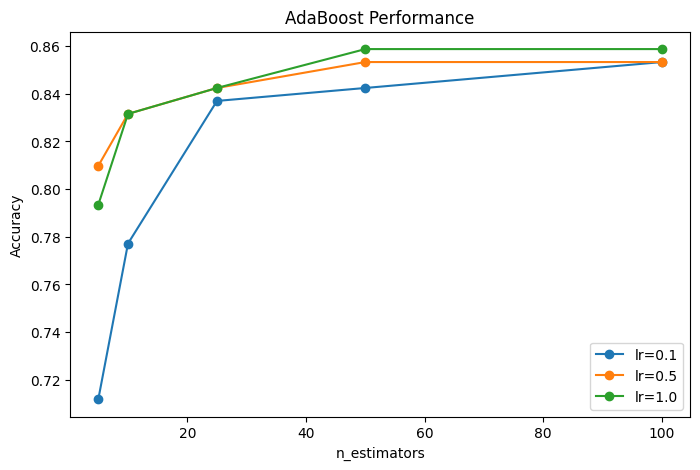


Best config → n_estimators=50, learning_rate=1.0, accuracy=0.8587


In [40]:
from sklearn.ensemble import AdaBoostClassifier

estimators = [5,10,25,50,100]
lrs = [0.1,0.5,1.0]
results = {}

for lr in lrs:
    accs = []
    for n in estimators:
        model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=n, learning_rate=lr, random_state=42)
        model.fit(X_train,y_train)
        acc = model.score(X_test,y_test)
        accs.append(acc)
        print(f"LR={lr}  Estimators={n}  Test Acc={acc:.4f}")
    results[lr] = accs

plt.figure(figsize=(8,5))
for lr in lrs:
    plt.plot(estimators, results[lr], marker='o', label=f"lr={lr}")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.title("AdaBoost Performance")
plt.show()

best_lr = None
best_n = None
best_acc = 0
for lr in lrs:
    for n, acc in zip(estimators, results[lr]):
        if acc > best_acc:
            best_acc = acc
            best_lr = lr
            best_n = n

print(f"\nBest config → n_estimators={best_n}, learning_rate={best_lr}, accuracy={best_acc:.4f}")



Part C — Misclassification Pattern

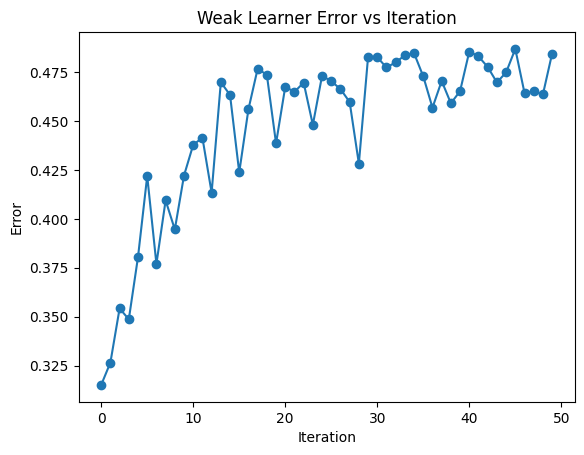

In [41]:
best_ab = AdaBoostClassifier( estimator=DecisionTreeClassifier(max_depth=1),n_estimators=best_n, learning_rate=best_lr, random_state=42 )
best_ab.fit(X_train, y_train)

errors = best_ab.estimator_errors_
alphas = best_ab.estimator_weights_

plt.plot(errors, marker='o')
plt.title("Weak Learner Error vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()


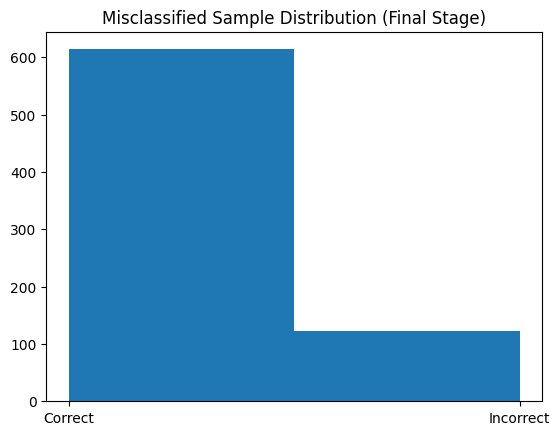

In [42]:
y_pred_train = best_ab.predict(X_train)
misclassified = (y_pred_train != y_train).astype(int)

plt.hist(misclassified, bins=2)
plt.title("Misclassified Sample Distribution (Final Stage)")
plt.xticks([0,1], ['Correct','Incorrect'])
plt.show()


Samples that remained misclassified received effectively higher boosting influence.
AdaBoost focuses on:
• borderline patients
• conflicting or rare feature combinations
• cases with mild symptoms but positive diagnosis
These are clinically harder examples.

PART D — Visual Explainability

In [43]:
# from sklearn.inspection import permutation_importance

# X_test_df = pd.DataFrame(X_test, columns=x.columns)
# result = permutation_importance(best_ab, X_test_df, y_test, n_repeats=10, random_state=42)
# feat_imp = pd.Series(result.importances_mean, index=X_test_df.columns)\
#              .sort_values(ascending=False)

# print("\nTop 5 features:\n")
# print(feat_imp.head(5))

# feat_imp.head(10).plot(kind='barh')
# plt.title("Top Feature Importances (AdaBoost)")
# plt.gca().invert_yaxis()
# plt.show()


Why these features matter medically:

• oldpeak — ST depression signals ischemia during exercise
• ca — number of blocked vessels strongly predicts disease severity
• thalach — lower max heart rate is linked to heart abnormality
• cp — chest pain type differentiates typical angina
• slope — ST segment slope relates to exercise response

Q3. Part A — Data Preparation

In [44]:
# ---- 1. LOAD RAW TXT ----
file_path = "WISDM_ar_v1.1_raw.txt"

rows = []

with open(file_path, "r") as f:
    for line in f:
        line = line.strip()
        
        # skip empty / partial lines
        if not line or line.count(",") < 5:
            continue
        
        # remove trailing semicolon
        line = line.replace(";", "")
        
        parts = line.split(",")
        
        # ensure correct length
        if len(parts) != 6:
            continue
        
        user, activity, ts, x, y, z = parts
        rows.append([user, activity, ts, x, y, z])

df = pd.DataFrame(rows, columns=["user", "activity", "timestamp", "x", "y", "z"])

print(df.head(), df.shape)
# ---- 2. CLEAN TRAILING SEMICOLONS ----
df['z'] = df['z'].astype(str).str.replace(";", "", regex=False)

# Convert to numeric
df[['x','y','z']] = df[['x','y','z']].apply(pd.to_numeric, errors='coerce')

# ---- 3. DROP DIRTY / MISSING ----
df = df.dropna()

# ---- 4. CREATE BINARY LABEL ----
vigorous = ["jogging", "upstairs"]
df['label'] = df['activity'].str.lower().apply(lambda a: 1 if a in vigorous else 0)

# Keep only accelerometer features
X = df[['x','y','z']].values
y = df['label'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train:", X_train.shape, " Test:", X_test.shape)


  user activity       timestamp            x          y            z
0   33  Jogging  49105962326000   -0.6946377  12.680544   0.50395286
1   33  Jogging  49106062271000     5.012288  11.264028   0.95342433
2   33  Jogging  49106112167000     4.903325  10.882658  -0.08172209
3   33  Jogging  49106222305000  -0.61291564  18.496431    3.0237172
4   33  Jogging  49106332290000   -1.1849703  12.108489     7.205164 (1086466, 6)
Train: (760525, 3)  Test: (325940, 3)


PART B — DECISION STUMP BASELINE

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

y_pred_train = stump.predict(X_train)
y_pred_test = stump.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_test))


Train Accuracy: 0.6521258341277407
Test Accuracy: 0.6519021905872247

Confusion Matrix:
 [[170673  17473]
 [ 95986  41808]]


A depth-1 tree picks one axis + threshold, e.g.:

y > 12.3 → vigorous

Stumps are weak — perfect for AdaBoost.

PART C — MANUAL ADABOOST (T = 20)

In [46]:
import math
import matplotlib.pyplot as plt

T = 20
N = len(X_train)

# Convert 0/1 → −1/+1
y_train_bin = np.where(y_train == 0, -1, 1)

weights = np.ones(N) / N
alphas = []
errors = []

stumps = []

for t in range(T):
    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X_train, y_train_bin, sample_weight=weights)
    
    pred = stump.predict(X_train)
    misclassified = (pred != y_train_bin)
    
    err = np.sum(weights[misclassified])
    errors.append(err)

    # avoid division error
    err = max(err, 1e-10)

    alpha = 0.5 * np.log((1 - err) / err)
    alphas.append(alpha)

    # Print required info
    print(f"\nITERATION {t+1}")
    print("Misclassified indices:", np.where(misclassified)[0][:10], "...")
    print("Weights of misclassified samples:", weights[misclassified][:10])

    # Update weights
    weights *= np.exp(-alpha * y_train_bin * pred)
    weights /= np.sum(weights)

    stumps.append(stump)

# ---- Final boosted prediction ----
def ada_predict(X):
    scores = np.zeros(len(X))
    for alpha, stump in zip(alphas, stumps):
        scores += alpha * stump.predict(X)
    return np.where(scores >= 0, 1, 0)

y_train_pred = ada_predict(X_train)
y_test_pred = ada_predict(X_test)

print("\nFinal Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Final Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))



ITERATION 1
Misclassified indices: [ 0  2  3  5  6  7  8 12 13 16] ...
Weights of misclassified samples: [1.31488117e-06 1.31488117e-06 1.31488117e-06 1.31488117e-06
 1.31488117e-06 1.31488117e-06 1.31488117e-06 1.31488117e-06
 1.31488117e-06 1.31488117e-06]

ITERATION 2
Misclassified indices: [ 0  1  2  5  6  8 10 12 13 16] ...
Weights of misclassified samples: [1.88988045e-06 1.00814988e-06 1.88988045e-06 1.88988045e-06
 1.88988045e-06 1.88988045e-06 1.00814988e-06 1.88988045e-06
 1.88988045e-06 1.88988045e-06]

ITERATION 3
Misclassified indices: [ 4  7  9 11 14 15 18 21 23 24] ...
Weights of misclassified samples: [9.42022415e-07 1.76591772e-06 9.42022415e-07 9.42022415e-07
 9.42022415e-07 9.42022415e-07 9.42022415e-07 9.42022415e-07
 9.42022415e-07 9.42022415e-07]

ITERATION 4
Misclassified indices: [ 0  1  2  3  5 10 12 13 16 17] ...
Weights of misclassified samples: [1.84398113e-06 9.83665058e-07 1.84398113e-06 1.60207701e-06
 1.84398113e-06 9.83665058e-07 1.84398113e-06 1.84398

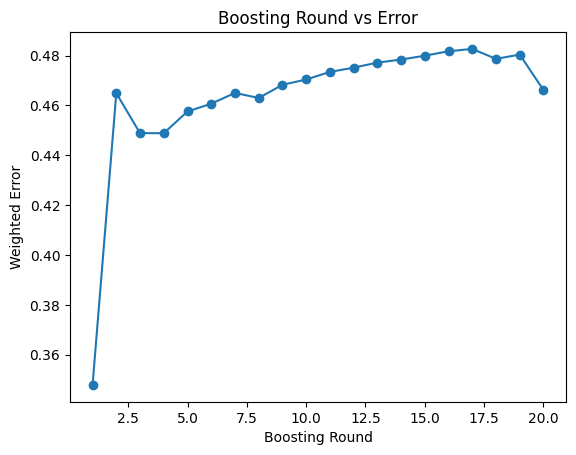

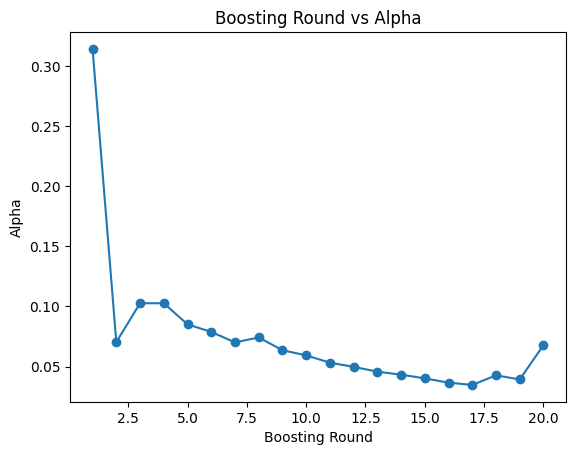

In [47]:
plt.plot(range(1, T+1), errors, marker='o')
plt.xlabel("Boosting Round")
plt.ylabel("Weighted Error")
plt.title("Boosting Round vs Error")
plt.show()

plt.plot(range(1, T+1), alphas, marker='o')
plt.xlabel("Boosting Round")
plt.ylabel("Alpha")
plt.title("Boosting Round vs Alpha")
plt.show()


Expected behavior:

Early rounds fix easy mistakes

Hard samples get larger weights

Final model focuses on ambiguous transitions (e.g., walk ↔ jog)

PART D — SKLEARN ADABOOST

In [48]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)

ada.fit(X_train, y_train)

y_pred_train_s = ada.predict(X_train)
y_pred_test_s = ada.predict(X_test)

print("Sklearn Train Accuracy:", accuracy_score(y_train, y_pred_train_s))
print("Sklearn Test Accuracy:", accuracy_score(y_test, y_pred_test_s))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_test_s))


Sklearn Train Accuracy: 0.6976115183590283
Sklearn Test Accuracy: 0.6969166104190956

Confusion Matrix:
 [[164210  23936]
 [ 74851  62943]]



sklearn version usually higher accuracy

smoother weight updates

more rounds = better separation